#Table of Contents
* [Walltime](#Walltime)
* [Speedup](#Speedup)
* [Memory consumption](#Memory-consumption)
* [Exact counting](#Exact-counting)
	* [Table](#Table)
* [Summaries description](#Summaries-description)
	* [Walltime stats](#Walltime-stats)
	* [Memory stats](#Memory-stats)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

# Walltime

In [2]:
%run ../scripts/bench_to_csv.py
THREADS = [1, 2, 4, 8, 16]
REPLICATES = range(1, 11)

In [3]:
summary_io = parse_exp('just-io', REPLICATES, dir='../benchmarks')
summary_hll = parse_exp('unique-kmers', REPLICATES, threads=THREADS, dir='../benchmarks')

In [4]:
def prepare_plot_data(summary_io, summary_hll, value):
    constant_line = None
    for t in THREADS:
        df = summary_io[['replicate', value, 'threads']].copy()
        df['threads'] = t
        df['condition'] = 'Just I/O'
        if constant_line is None:
            constant_line = df
        else:
            constant_line = constant_line.append(df, ignore_index=True)

    plot_hll = summary_hll[['replicate', value, 'threads']].copy()
    plot_hll['condition'] = 'Parallel HLL'

    return plot_hll.append(constant_line, ignore_index=True)

In [5]:
def tsplot(plot_data, value, unit_traces=False):
    majorFormatter = FormatStrFormatter('%d')

    err_style = 'ci_band'
    if unit_traces:
        err_style = 'unit_traces'

    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    sns.tsplot(plot_data, ax=ax, ci=95, 
               err_style=err_style,
               linestyle='-', marker='o',
               time="threads", unit='replicate', condition='condition',
               value=value)
    ax.lines[-1].set_linestyle("--")
    ax.lines[-1].set_marker("s")
    ax.set_xscale("log", basex=2)
    ax.xaxis.set_major_formatter(majorFormatter)

    ax.set_yscale("log", basey=2)
    ax.yaxis.set_major_formatter(majorFormatter)

    ax.legend(loc='best')
    
    return fig

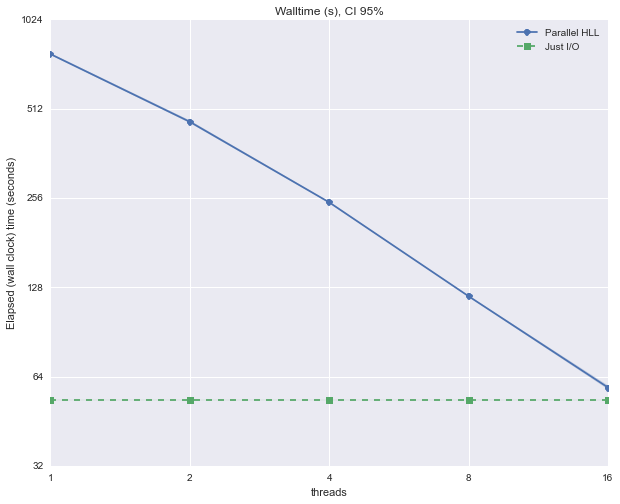

In [6]:
plot_data_walltime = prepare_plot_data(summary_io, summary_hll, 'Elapsed (wall clock) time (seconds)')
fig = tsplot(plot_data_walltime, "Elapsed (wall clock) time (seconds)")
ax = fig.gca()
ax.set_title("Walltime (s), CI 95%")
fig.savefig('../manuscript/figures/io_bound.png')

# Speedup

In [7]:
speedup_base_hll = (plot_data_walltime
  [(plot_data_walltime["threads"] == 1) & (plot_data_walltime["condition"] == "Parallel HLL")]
  ["Elapsed (wall clock) time (seconds)"]
  .median())

speedup_base_io = (plot_data_walltime
  [(plot_data_walltime["threads"] == 1) & (plot_data_walltime["condition"] == "Just I/O")]
  ["Elapsed (wall clock) time (seconds)"]
  .median())

In [8]:
plot_data_walltime['speedup'] = speedup_base_hll / plot_data_walltime["Elapsed (wall clock) time (seconds)"]

plot_data_walltime.loc[(plot_data_walltime['condition'] == "Just I/O", "speedup")] = (
    speedup_base_io / 
    plot_data_walltime.loc[(plot_data_walltime['condition'] == "Just I/O")]
      ["Elapsed (wall clock) time (seconds)"])

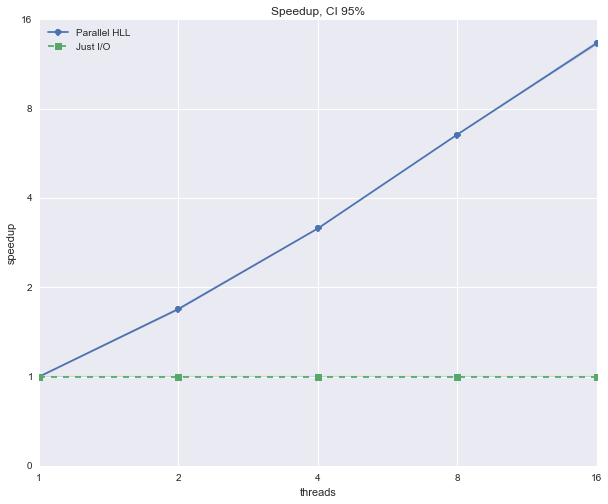

In [9]:
fig = tsplot(plot_data_walltime, "speedup")
ax = fig.gca()
ax.set_title("Speedup, CI 95%")
fig.savefig('../manuscript/figures/io_bound.png')

# Memory consumption

In [10]:
plot_data_mem = prepare_plot_data(summary_io, summary_hll, 'Maximum resident set size (kbytes)')

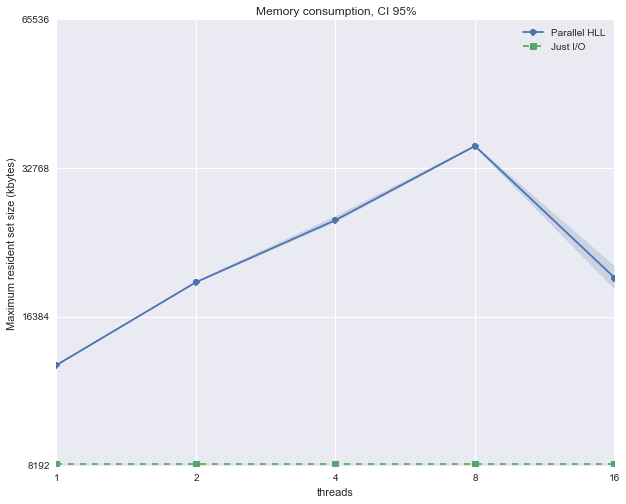

In [11]:
fig = tsplot(plot_data_mem, "Maximum resident set size (kbytes)")
ax = fig.gca()
ax.set_title("Memory consumption, CI 95%")
fig.savefig('../manuscript/figures/mem_consumption.png')

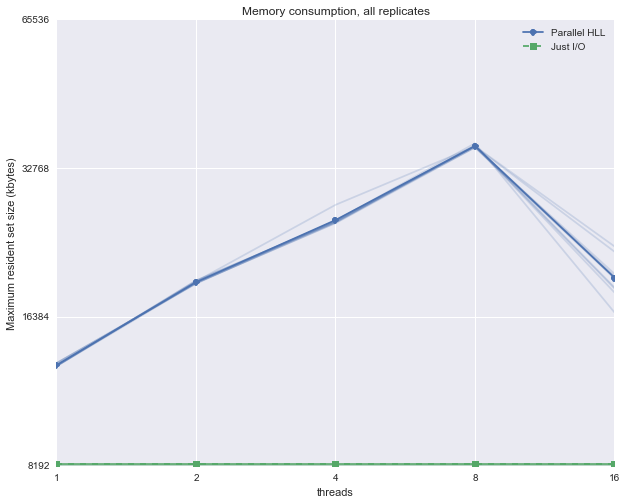

In [12]:
fig = tsplot(plot_data_mem, "Maximum resident set size (kbytes)", unit_traces=True)
ax = fig.gca()
ax.set_title("Memory consumption, all replicates")
fig.savefig('../manuscript/figures/mem_consumption_unit_traces.png')

# Exact counting

In [13]:
summaries = {}
n_unique_kmers = {}

n_unique_kmers['small'] = {
  'py': 670487,
  'sparsehash': 670487,
  'hll': 670328
}

n_unique_kmers['medium'] = {
  'py': 17510301,
  'sparsehash': 17510301,
  'hll': 17686322
}

summaries['small'] = {
  'py':         parse_exp('exact-py-small', REPLICATES, dir='../benchmarks'),
  'sparsehash': parse_exp('exact-sparsehash-small', range(1, 11), dir='../benchmarks'),
  'hll':        parse_exp('hll-small', REPLICATES, dir='../benchmarks')
}
    
summaries['medium'] = {
  'py':         parse_exp('exact-py-medium', REPLICATES, threads=THREADS, dir='../benchmarks'),
  'sparsehash': parse_exp('exact-sparsehash-medium', range(1, 11), threads=THREADS, dir='../benchmarks'),
  'hll':        parse_exp('hll-medium', REPLICATES, threads=THREADS, dir='../benchmarks')
}

In [14]:
final_df = pd.DataFrame()
for size in ('small', 'medium'):
    df = pd.DataFrame()
    for src, summary in summaries[size].items():
        sr = summary[['Maximum resident set size (kbytes)', 'Elapsed (wall clock) time (seconds)']].mean()
        sr['condition'] = src
        sr['cardinality'] = n_unique_kmers[size][src]
        df = df.append(sr, ignore_index=True)
    df['size'] = size
    exact =  df[df['condition'] == 'sparsehash']['cardinality'].values[0]
    df['error (%)'] = abs((df['cardinality'] - exact) / exact) * 100
    final_df = final_df.append(df, ignore_index=True)

## Table

In [15]:
final_df.groupby(('size', 'condition')).first()

Elapsed (wall clock) time (seconds)  \
size   condition                                         
medium hll                                      12.080   
       py                                      891.171   
       sparsehash                              344.041   
small  hll                                       0.193   
       py                                        4.306   
       sparsehash                                3.888   

                   Maximum resident set size (kbytes)  cardinality  error (%)  
size   condition                                                               
medium hll                                    13376.4     17686322   1.005243  
       py                                   2056048.0     17510301   0.000000  
       sparsehash                           2018502.4     17510301   0.000000  
small  hll                                    13439.6       670328   0.023714  
       py                                     83476.4       670487   0.000000  
       sparsehash                             77636.0       670487   0.000000

# Summaries description

## Walltime stats

In [16]:
summary_io['Elapsed (wall clock) time (seconds)'].describe()

count    10.00000
mean     53.20500
std       0.03504
min      53.14000
25%      53.19000
50%      53.20000
75%      53.23750
max      53.25000
Name: Elapsed (wall clock) time (seconds), dtype: float64

In [17]:
(summary_hll[['Elapsed (wall clock) time (seconds)', 'threads']]
   .groupby('threads')
   .describe())

Elapsed (wall clock) time (seconds)
threads                                           
1       count                            10.000000
        mean                            783.175000
        std                               7.440867
        min                             777.420000
        25%                             777.810000
        50%                             781.220000
        75%                             785.412500
        max                             801.540000
2       count                            10.000000
        mean                            462.788000
        std                               6.826403
        min                             452.340000
        25%                             460.175000
        50%                             462.035000
        75%                             462.697500
        max                             479.120000
4       count                            10.000000
        mean                            247.529000
        std                               1.733150
        min                             244.760000
        25%                             246.460000
        50%                             247.680000
        75%                             248.945000
        max                             249.720000
8       count                            10.000000
        mean                            119.351000
        std                               0.593623
        min                             118.540000
        25%                             118.910000
        50%                             119.260000
        75%                             119.732500
        max                             120.400000
16      count                            10.000000
        mean                             58.731000
        std                               1.391518
        min                              57.290000
        25%                              57.625000
        50%                              58.445000
        75%                              59.162500
        max                              61.340000

## Memory stats

In [18]:
summary_io['Maximum resident set size (kbytes)'].describe()

count      10.000000
mean     8244.400000
std         2.951459
min      8240.000000
25%      8244.000000
50%      8244.000000
75%      8247.000000
max      8248.000000
Name: Maximum resident set size (kbytes), dtype: float64

In [19]:
(summary_hll[['Maximum resident set size (kbytes)', 'threads']]
   .groupby('threads')
   .describe())

Maximum resident set size (kbytes)
threads                                          
1       count                           10.000000
        mean                         13095.600000
        std                             84.294721
        min                          13020.000000
        25%                          13034.000000
        50%                          13060.000000
        75%                          13178.000000
        max                          13216.000000
2       count                           10.000000
        mean                         19267.200000
        std                            105.507030
        min                          19124.000000
        25%                          19183.000000
        50%                          19248.000000
        75%                          19338.000000
        max                          19420.000000
4       count                           10.000000
        mean                         25734.400000
        std                            671.577116
        min                          25360.000000
        25%                          25472.000000
        50%                          25536.000000
        75%                          25642.000000
        max                          27624.000000
8       count                           10.000000
        mean                         36335.200000
        std                            208.134999
        min                          36092.000000
        25%                          36200.000000
        50%                          36328.000000
        75%                          36413.000000
        max                          36804.000000
16      count                           10.000000
        mean                         19676.800000
        std                           1768.753786
        min                          16736.000000
        25%                          18733.000000
        50%                          19672.000000
        75%                          19977.000000
        max                          22764.000000